# Emission Measure Bin Width Testing

Need to resolve issue of how to calculate bin width. Should it be divided by the bin width? Run some tests with the single-fluid EBTEL code and our EM binner class to find out.

In [1]:
#Import needed modules
import sys
from imp import reload
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('/home/wtb2/Documents/sunFM/')
sys.path.append('/home/wtb2/Documents/EBTEL_C/bin/')
import em_binner as eb
import ebtel_wrapper as ew
reload(eb)
reload(ew)

/usr/lib/python3/dist-packages/matplotlib/__init__.py:1175: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ebtel_wrapper' from '/home/wtb2/Documents/EBTEL_C/bin/ebtel_wrapper.py'>

First, set up the EBTEL run.

In [2]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 5000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.4e-6
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
config_dict['sample_rate'] = 1
config_dict['output_file'] = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/em_bin_tests'

In [3]:
ew.print_xml_config(config_dict,config_file=config_dict['output_file']+'.xml')

Now, run the model and save the output.

In [4]:
ew.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',config_file=config_dict['output_file']+'.xml')

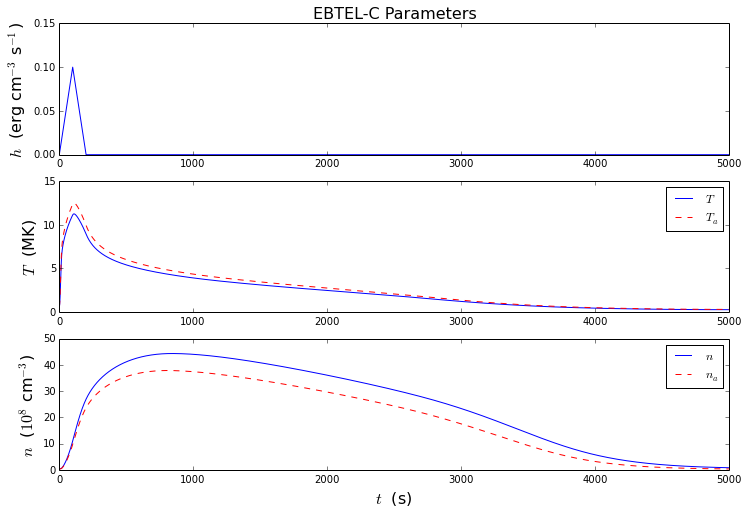

In [5]:
ew.plot_ebtel('',config_dict['output_file']+'.txt')

In [6]:
results = np.loadtxt(config_dict['output_file']+'.txt')
results_em = np.loadtxt(config_dict['output_file']+'_dem.txt')

Instantiate the binner class.

In [7]:
binner = eb.EM_Binner(results[:,0],results[:,1],results[:,2],2*config_dict['loop_length']*10**8)

In [8]:
binner.logT_bins(delta_logT=0.01)
binner.build_em_dist()

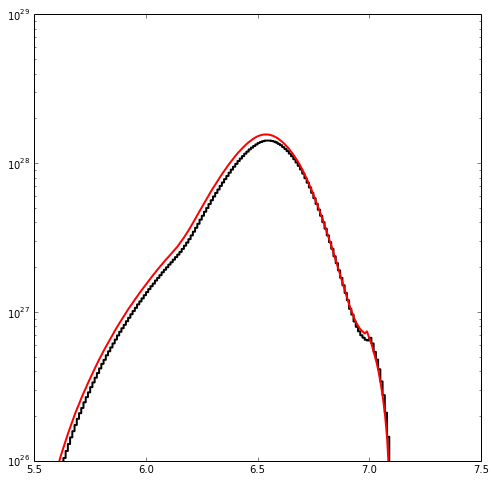

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.hist(binner.logT_em_flat,bins=binner.logT_EM_histo_bins,weights=np.array(binner.em_flat),
        histtype='step',linewidth=2,color='k')
ax.plot(results_em[:,0],10**results_em[:,4],color='r',linewidth=2)
ax.set_xlim([5.5,7.5])
ax.set_ylim([1e+26,1e+29])
ax.set_yscale('log')
plt.show()

Now, let's look at a bunch of different bin sizes and check the integral over the entire temperature range to make sure it is being conserved.

In [18]:
bin_sizes = np.linspace(0.001,0.5,36)

In [19]:
def vary_bin_width(binner_object,axes_object,ebtel_em,bin_sizes,itr):
    #Create new bins
    binner_object.logT_bins(delta_logT=bin_sizes[itr])
    #Get EMs
    binner_object.build_em_dist()
    #Add to axes
    n,bins,patches = axes_object.hist(binner_object.logT_em_flat,
                                      bins=binner_object.logT_EM_histo_bins,
                                      weights=np.array(binner_object.em_flat),histtype='step',
                                      linewidth=2,color='k')
    axes_object.plot(ebtel_em[0],ebtel_em[1],linewidth=2,color='r')
    #Calculate integral
    em_int = 1.0/np.log(10)*np.sum(n*np.diff(bins)*10**(bins[:-1]))
    #Set title
    axes_object.set_title(r'$\Delta\log{T}=$%.3f'%bin_sizes[itr])
    #print(r'$\Delta\log{T}=$%.3f, $\int dT\,\mathrm{EM}$=%.3e'%(bin_sizes[itr],em_int))
    #Additional cosmetics
    axes_object.set_yscale('log')
    axes_object.set_xlim([5.5,7.5])
    axes_object.set_ylim([1e+26,1e+29])
    axes_object.set_xticks([])
    axes_object.set_yticks([])
    
    return em_int

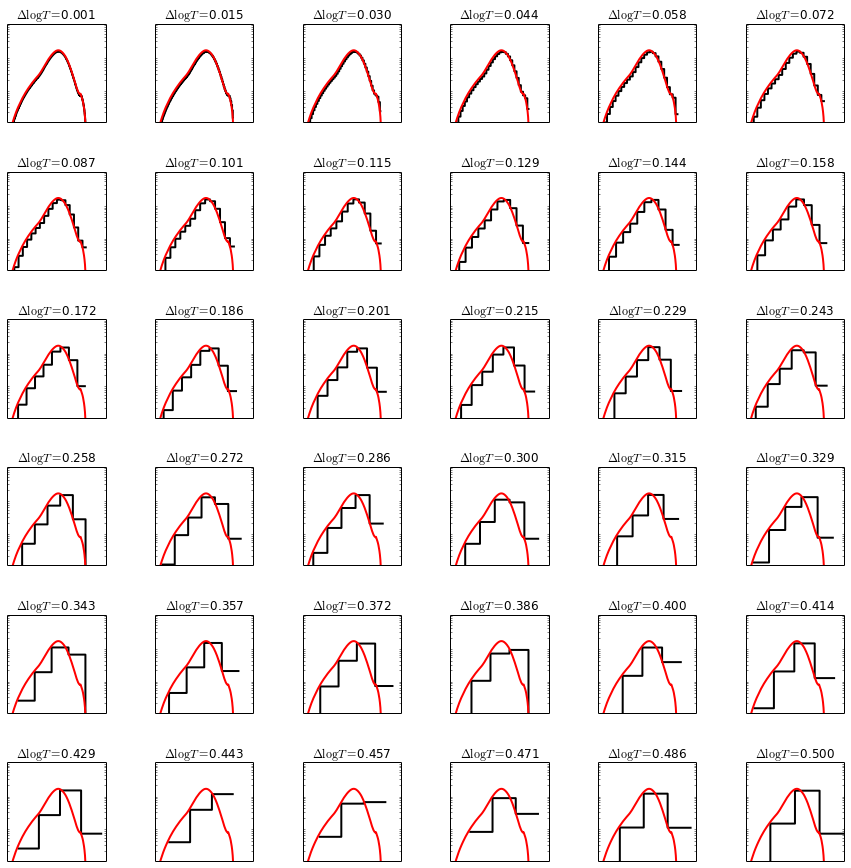

In [20]:
#Set up figure
em_int_array = []
fig,axes = plt.subplots(int(np.sqrt(len(bin_sizes))),int(np.sqrt(len(bin_sizes))),
                        figsize=(15,15))
axes_flat = axes.flatten()
plt.subplots_adjust(hspace=0.5,wspace=0.5)
for i in range(len(axes_flat)):
    em_int = vary_bin_width(binner,axes_flat[i],[results_em[:,0],10**results_em[:,4]],
                            bin_sizes,i)
    em_int_array.append(em_int)
    
em_int_array = np.array(em_int_array)

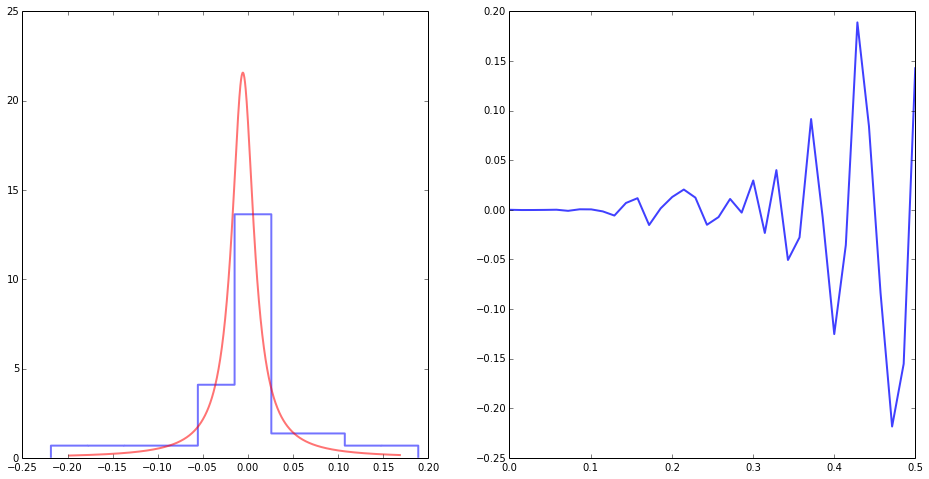

In [21]:
#get error
em_int_abs = em_int_array[0]
em_int_array_norm = (em_int_array - em_int_abs)/em_int_abs
#setup figure
fig,ax = plt.subplots(1,2,figsize=(16,8))
#construct histogram
hist,bin_edges,patches = ax[0].hist(em_int_array_norm,histtype='step',linewidth=2,alpha=0.55
                                ,normed=True,bins=10)
bin_centers =  (bin_edges[:-1] + bin_edges[1:])/2.0
#define gaussian to fit to
def lorentzian(x,mu,sigma):
    return 1.0/np.pi*0.5*sigma/((x-mu)**2 + (0.5*sigma)**2)
#fit curve
x = np.linspace(bin_centers[0],bin_centers[-1],1000)
coeff,var_mat = curve_fit(lorentzian,bin_centers,hist)
#get the curve
hist_fit = lorentzian(x,*coeff)
#plot
ax[0].plot(x,hist_fit,color='r',linewidth=2,alpha=0.55)
ax[1].plot(bin_sizes,(em_int_array_norm),linewidth=2,color='b',alpha=0.75)
#draw
plt.show()